In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils.network as network_class
import utils.lstm_model as lstm_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer as data_processer_functions

import torch
import torch.nn as nn

import pickle
from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version', torch.version.cuda)
print('PyTorch Version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3
PyTorch Version 1.12.1


# Define Network 

In [3]:
num_nodes = 6
num_edges = 6

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1, 0, 0, 0, 0, 0], # -1 => node is edge's source
                                [ 1,-1, 0,-1, 0, 0], # 1 => node is edge's destination
                                [ 0, 1,-1, 0, 0, 0],
                                [ 0, 0, 0, 1,-1, 0],
                                [ 0, 0, 1, 0, 1,-1],
                                [ 0, 0, 0, 0, 0, 1]])

num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,1,0,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[0,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[0,:] = 2*np.array([0,1,1,0,0,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,0,1,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[1,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[1,:] = 2*np.array([0,0,0,1,1,1])

### Get Network Class

In [4]:
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

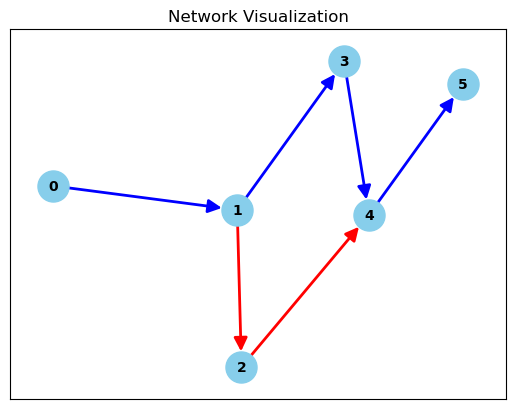

In [5]:
my_network.visualize(custom_seed = 1)

# Simulate Network

In [6]:
packets_in_flight_og, tunnel_backlogs_og, tunnel_injections_og, tunnel_exits_og = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

In [7]:
T_start = 20
packets_in_flight, tunnel_backlogs, tunnel_injections, tunnel_exits = \
    packets_in_flight_og[T_start:,], tunnel_backlogs_og[T_start:,], tunnel_injections_og[T_start:,], tunnel_exits_og[T_start:,]

# Model Training

In [8]:
def plot_scatter_plot(x_in, y_in, title):
    plt.scatter(x_in[:, 1], x_in[:, 0], c = y_in, cmap='viridis', s=5, alpha=0.7)
    plt.xlabel('Packets in flight tunnel 1')
    plt.ylabel('Packets in flight tunnel 0')
    cbar = plt.colorbar()
    cbar.set_label(title)
    plt.show()
    
def plot_predicted_scatter(x_in, y, y_pred, tunnel_title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

    scatter1 = axs[0].scatter(x_in[:, 1], x_in[:, 0], c = y, cmap='viridis', s=5, alpha=0.7)
    axs[0].set_xlabel('Packets in flight tunnel 1')
    axs[0].set_ylabel('Packets in flight tunnel 0')
    colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    colorbar1.set_label('True backlogs ' + tunnel_title)

    scatter2 = axs[1].scatter(x_in[:, 1], x_in[:, 0], c = y_pred, cmap='viridis', s=5, alpha=0.7)
    axs[1].set_xlabel('Packets in flight tunnel 1')
    axs[1].set_ylabel('Packets in flight tunnel 0')
    colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    colorbar2.set_label('Predicted backlogs ' + tunnel_title)

    plt.tight_layout()
    plt.show()
    
def running_average(arr, window_size = 1000):
    arr = np.concatenate((np.zeros([window_size,]), arr), axis=0)
    cumsum = np.cumsum(arr)
    running_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return running_avg

def plot_queue_evolution(y, y_pred, tunnel_ii):
    T_to_plot = 5000
    window_size = 1
    plt.plot(running_average(y[:T_to_plot,tunnel_ii], window_size), label = 'True backlog')
    plt.plot(running_average(y_pred[:T_to_plot,tunnel_ii], window_size), label = 'Predicted backlog')
    plt.xlabel('Time')
    plt.ylabel('Tunnel backlogs of tunnel '+str(tunnel_ii))
    plt.legend()
    plt.show()

def plot_tunnel_scatter_plot(x, y, y_pred, tunnel_ii): 
    tt = -1 
    fig,ax=plt.subplots()
    ax.scatter(x[:,tt,tunnel_ii], y[:,tunnel_ii], label='True backlog', cmap='viridis', s=6, alpha=0.7)
    ax.scatter(x[:,tt,tunnel_ii], y_pred[:,tunnel_ii], label='Predicted backlog', cmap='viridis', s=6, alpha=0.5)
    ax.legend()
    ax.set_xlabel('Packets in flight tunnel '+str(tunnel_ii))
    ax.set_ylabel('Queue backlogs tunnel '+str(tunnel_ii))
    plt.show()

In [9]:
def prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    packets_in_flight_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    tunnel_injections_all = data_processer.create_sequences(torch.Tensor(tunnel_injections), look_back).to(device)
    tunnel_exits_all = data_processer.create_sequences(torch.Tensor(tunnel_exits), look_back).to(device)

    # create x values from packets in flight, tunnel injections, and exits
    x_all = data_processer.feature_transform(device, packets_in_flight_all)
    x_all = torch.concat((x_all, tunnel_injections_all), dim=-1)
    x_all = torch.concat((x_all, tunnel_exits_all), dim=-1)
    
    # create y values from queue backlogs
    y_all = torch.Tensor(tunnel_backlogs).to(device)

    # split into train and test
    x_train_unscaled, y_train_unscaled, x_test_unscaled, y_test_unscaled = data_processer.split_train_test(x_all, y_all)

    # rescale to [0,1]
    x_train, y_train = data_processer.scale_train(x_train_unscaled, y_train_unscaled, is_x_sequenced = True)
    x_test, y_test = data_processer.scale_test(x_test_unscaled, y_test_unscaled)

    return data_processer, x_train, y_train, x_test, y_test

In [10]:
def define_and_train_model(device, hidden_sizes, learning_rate, num_epochs, x_train, y_train, gamma_value):
    # seeds  for reproducibility
    np.random.seed(0)
    torch.manual_seed(0)

    # define model with given hidden_sizes
    input_size  = x_train.shape[-1]
    output_size = y_train.shape[-1]
    lstm_predictor = lstm_model_class.LSTMModel(input_size, hidden_sizes, output_size).to(device)

    # define tools for training with given hyperparameters
    trainer = model_trainer_class.modelTrainer(criterion = nn.SmoothL1Loss(beta=0.6), device = device)
    optimizer = torch.optim.Adam(lstm_predictor.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_value)

    # training loop
    pbar = trange(num_epochs)
    for epoch in pbar:
        # perform a training epoch using full x_train dataset as data size is small enough
        loss_value = trainer.batch_step(lstm_predictor, x_train, y_train, optimizer) 
        pbar.set_postfix({'epoch': f'{epoch+1}/{num_epochs}', 'loss': loss_value, 'look_back': x_train.shape[1], 'hidden_sizes': str(hidden_sizes), 'learning_rate': learning_rate})
        scheduler.step()

    return lstm_predictor

In [11]:
def get_error_rates(lstm_predictor, x, y, data_processer, round_prediction = True):
    # get predictions
    lstm_predictor.eval()
    y_pred = lstm_predictor.evaluate(x)

    # rescale back to queue sizes
    _, y_pred_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y_pred)
    x_unscaled, y_unscaled = data_processer.inverse_scale(x_scaled=x, y_scaled=y)
    if(round_prediction): y_pred_unscaled = np.round(y_pred_unscaled.cpu().numpy())
    else: y_pred_unscaled = y_pred_unscaled.cpu().numpy()
    y_unscaled = y_unscaled.cpu().numpy()

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False) 
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100 
    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, x_unscaled.cpu().numpy(), y_unscaled, y_pred_unscaled

In [12]:
def train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, hidden_sizes, learning_rate, num_epochs, gamma_value):
    # prepare data
    data_processer, x_train, y_train, x_test, y_test = prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back)

    # define and train model
    lstm_predictor = define_and_train_model(device, hidden_sizes, learning_rate, num_epochs, x_train, y_train, gamma_value)

    # get performance metrics
    train_error_rates, _,_, _ = get_error_rates(lstm_predictor, x_train, y_train, data_processer)
    test_error_rates, _, _,_ = get_error_rates(lstm_predictor, x_test, y_test, data_processer)
    error_metrics = {'train': train_error_rates, 'test': test_error_rates}
    
    return lstm_predictor, error_metrics

In [13]:
reload(data_processer_functions)
reload(lstm_model_class)
reload(model_trainer_class)

# create hyperparamer lists to explore
look_back_list = [15] # [10, 15]
hidden_sizes_list = [[30,20,10,20]] #[[30,20,10,20], [10,20,10,5]]
learning_rate_list = [1e-2] #[1e-2]

num_epochs = 400 #400
gamma_value = 0.9995 # 0.9995

saved_models = [] 
for look_back in look_back_list:
    for hidden_sizes in hidden_sizes_list:
        for learning_rate in learning_rate_list:
            # train and test the model
            model, error_metrics = train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, hidden_sizes, learning_rate, num_epochs, gamma_value)

            # save trained model
            saved_models.append({
                        'model' : model,
                        'look_back': look_back,
                        'learning_rate': learning_rate,
                        'hidden_size' : hidden_sizes,
                        'error_metrics': error_metrics
                    })
            
# sort models according to best test rmse error
saved_models.sort(key = lambda x: (x['error_metrics']['test']['rmse'], x['error_metrics']['test']['mape'])) # (future): technically should have validation data and sort according to that 

100%|██████████| 400/400 [01:56<00:00,  3.42it/s, epoch=400/400, loss=0.00208, look_back=15, hidden_sizes=[30, 20, 10, 20], learning_rate=0.01]


In [14]:
# print hyperparameter tuning summary
print('Best LSTM model parameters:')
pprint({k: saved_models[0][k] for k in saved_models[0].keys() - {'model'}})

print('\nPerformance of all models:')
for ii in range(len(saved_models)):
    print(str(ii), saved_models[ii]['learning_rate'], saved_models[ii]['error_metrics'])

print(f'\n[{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}]')    

Best LSTM model parameters:
{'error_metrics': {'test': {'mape': 10.1455457508564, 'rmse': 7.438054},
                   'train': {'mape': 10.021505504846573, 'rmse': 8.280018}},
 'hidden_size': [30, 20, 10, 20],
 'learning_rate': 0.01,
 'look_back': 15}

Performance of all models:
0 0.01 {'train': {'rmse': 8.280018, 'mape': 10.021505504846573}, 'test': {'rmse': 7.438054, 'mape': 10.1455457508564}}

[13/12/2023 22:35:57]


In [15]:
# file_name = 'final_network2'
# with open(file_name + '_saved_lstm_model.pkl', 'wb') as file: pickle.dump(saved_models[0], file)
# with open(file_name + '_saved_lstm_model.pkl', 'rb') as file: loaded_model = pickle.load(file)

In [23]:
# recreate best model performance
look_back = saved_models[0]['look_back']
lstm_predictor = saved_models[0]['model']

# look_back = loaded_model['look_back']
# lstm_predictor = loaded_model['model']

# prepare data
data_processer, x_train, y_train, x_test, y_test = prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back)

In [24]:
# get train performance metrics
train_error_rates, x_train_final, y_train_final, y_pred_train_final = get_error_rates(lstm_predictor, x_train, y_train, data_processer, round_prediction=False)
print('Final train unrounded performance of the best model:')
pprint(train_error_rates)

# get test performance metrics
test_error_rates, x_test_final, y_test_final, y_pred_test_final = get_error_rates(lstm_predictor, x_test, y_test, data_processer, round_prediction=False)
print('Final test unrounded performance of the best model:')
pprint(test_error_rates)

c:\Users\Windows\Anaconda3\envs\env_chadaga\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Final train unrounded performance of the best model:
{'mape': 10.030803829431534, 'rmse': 8.276108}
Final test unrounded performance of the best model:
{'mape': 10.15491709113121, 'rmse': 7.437625}


c:\Users\Windows\Anaconda3\envs\env_chadaga\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


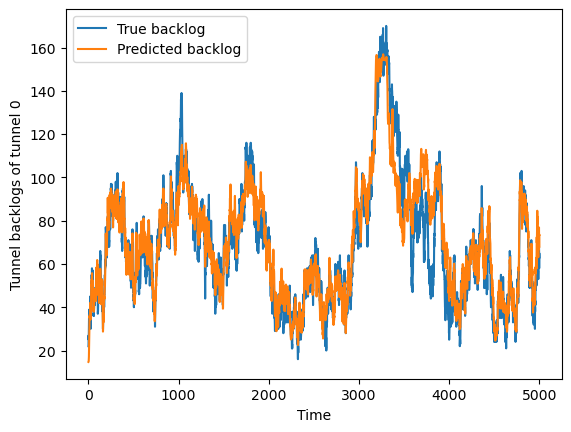

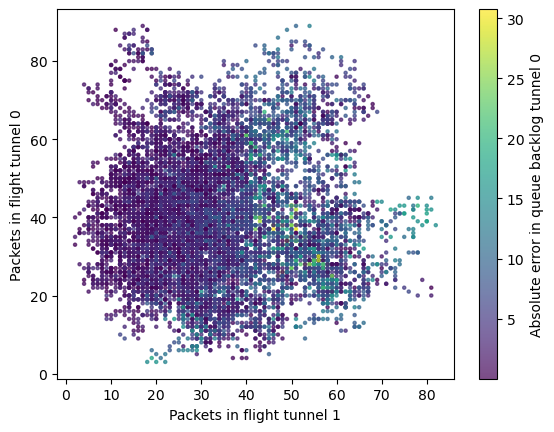

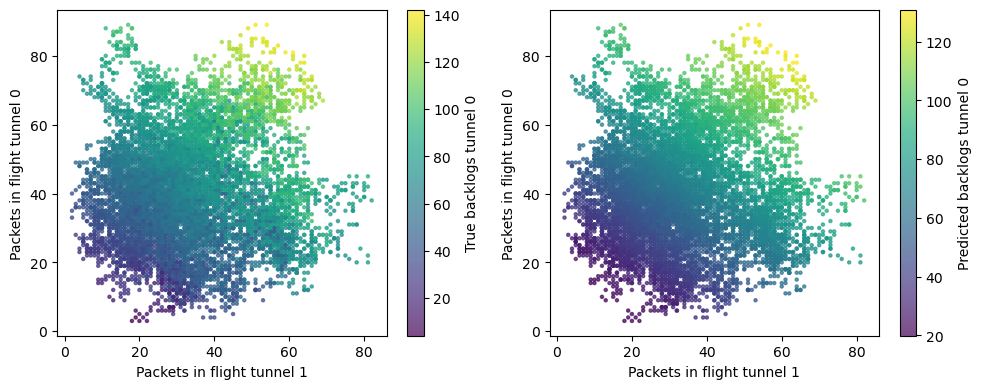

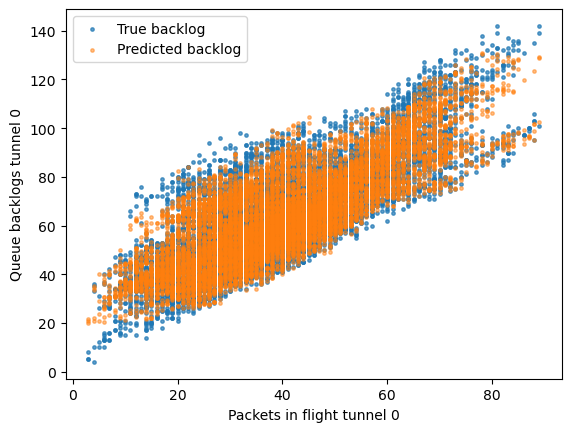

In [20]:
tt = -1
tunnel_ii = 0
plot_queue_evolution(y_train_final, y_pred_train_final, tunnel_ii)
plot_scatter_plot(x_test_final[:,tt,:], np.abs(y_test_final[:,tunnel_ii] - y_pred_test_final[:,tunnel_ii]), 'Absolute error in queue backlog tunnel '+str(tunnel_ii))
plot_predicted_scatter(x_test_final[:,tt,:], y_test_final[:,tunnel_ii], y_pred_test_final[:,tunnel_ii], tunnel_title = 'tunnel '+str(tunnel_ii))
plot_tunnel_scatter_plot(x_test_final, y_test_final, y_pred_test_final, tunnel_ii)

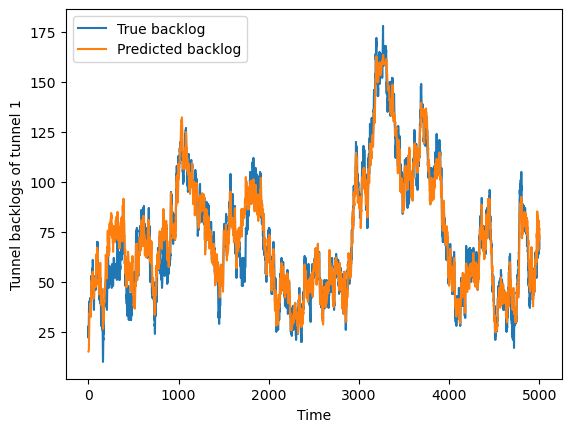

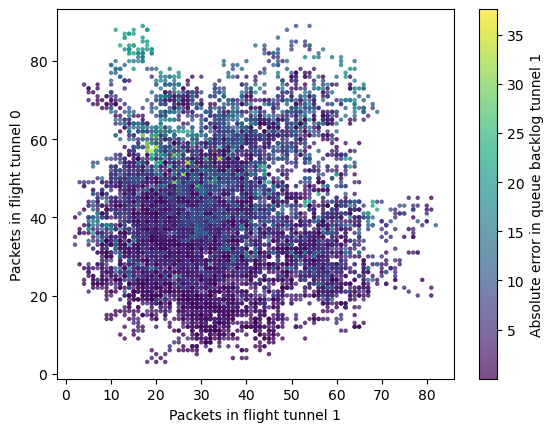

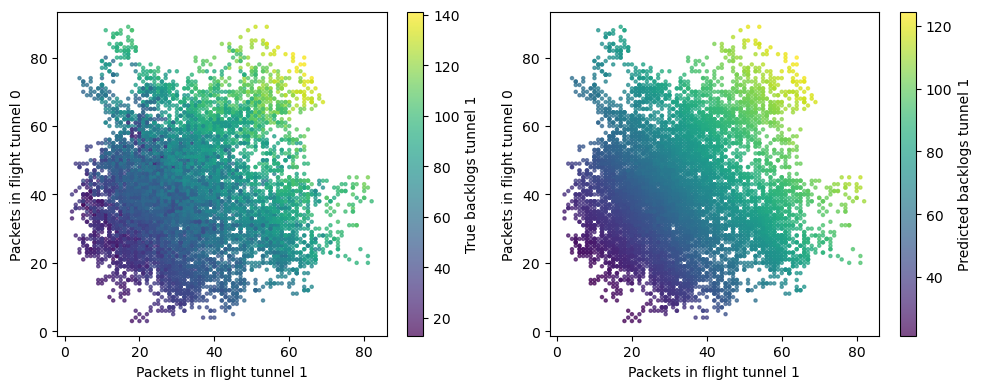

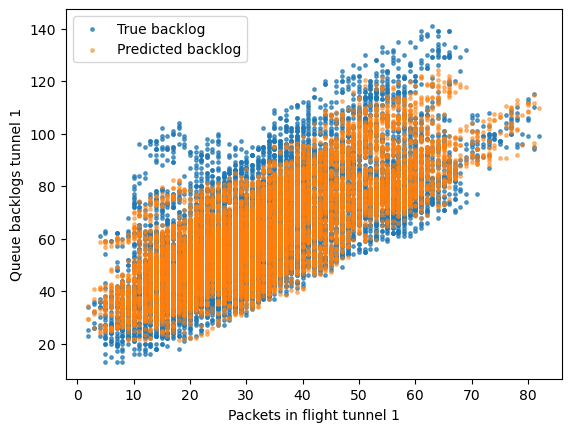

In [21]:
tt = -1
tunnel_ii = 1
plot_queue_evolution(y_train_final, y_pred_train_final, tunnel_ii)
plot_scatter_plot(x_test_final[:,tt,:], np.abs(y_test_final[:,tunnel_ii] - y_pred_test_final[:,tunnel_ii]), 'Absolute error in queue backlog tunnel '+str(tunnel_ii))
plot_predicted_scatter(x_test_final[:,tt,:], y_test_final[:,tunnel_ii], y_pred_test_final[:,tunnel_ii], tunnel_title = 'tunnel '+str(tunnel_ii))
plot_tunnel_scatter_plot(x_test_final, y_test_final, y_pred_test_final, tunnel_ii)